In [1]:
# 调用米筐API
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import datetime as dt
import os
import re
import statistics
import math
import time
from scipy.stats import norm
import copy
from matplotlib import pyplot as plt
# import option_culculate as oc
import rqdatac

In [7]:
path_in = 'E:/python/volatility_trading/'

In [3]:
# 读取文件
def open_pickle(path_in, file_name):
    import pickle
    tmp = pickle.load(open(path_in + file_name, "rb"))
    return tmp

def write_pickle(path_in, file_name, var_in):
    import pickle
    pickle.dump(var_in, open(path_in + file_name, "wb"))

In [4]:
# 时间设定
today = dt.datetime.today().strftime('%Y%m%d')

def get_main(code):
    return rqdatac.futures.get_dominant(code, today)

In [3]:
underlying = 'cu'
r = 0.02
t0 = pd.to_datetime('2021-01-01') 
t1 = t0 + dt.timedelta(weeks=52)
t2 = t1 + dt.timedelta(weeks=52)
idx = pd.IndexSlice

In [4]:
contract = []
for i in range(53):
    contract += rqdatac.options.get_contracts(underlying, trading_date = (dt.datetime.today() -  dt.timedelta(weeks=i)).strftime('%Y%m%d'))

contracts = np.unique(contract)
len(np.unique(contract))

RuntimeError: rqdatac is not initialized

In [ ]:
contracts = pd.read_csv(path_in + 'contracts_cu.csv')
contracts = contracts['0'].to_list()
call = pd.Series(contracts)[pd.Series(contracts).str.contains('C')]
put = pd.Series(contracts)[pd.Series(contracts).str.contains('P')]

In [48]:
contracts

array(['CU2209C49000', 'CU2209C50000', 'CU2209C51000', ...,
       'CU2402P73000', 'CU2402P74000', 'CU2402P75000'], dtype='<U12')

In [49]:
# 可跳过该部直接从open pickle开始

d_21 = rqdatac.get_price(contracts, start_date='2021-01-01', end_date='2021-12-31', frequency= '15m', fields=None, adjust_type='pre', skip_suspended =False, market='cn', expect_df=True,time_slice=None)

d_22 = rqdatac.get_price(contracts, start_date='2022-01-01', end_date='2022-12-31', frequency= '15m', fields=None, adjust_type='pre', skip_suspended =False, market='cn', expect_df=True,time_slice=None)

d_23 = rqdatac.get_price(contracts, start_date='2023-01-01', end_date='2023-07-21', frequency= '1d', fields=None, adjust_type='pre', skip_suspended =False, market='cn', expect_df=True,time_slice=None)

d_23 = rqdatac.get_price(contracts, start_date='2023-01-01', end_date='2023-07-21', frequency= '15m', fields=None, adjust_type='pre', skip_suspended =False, market='cn', expect_df=True,time_slice=None)


In [51]:
d = d.rename_axis(index = ['order_book_id', 'date'])

In [52]:
# multi-index dataframe
idx = pd.IndexSlice

# 期权名称
d['options'] = d.index.get_level_values('order_book_id')
# 期权类型
d['type'] = list(map(lambda x: re.sub('[^CP]', "", re.sub("[a-z0-9]", "", x[2:])), d.index.get_level_values('order_book_id')))
# 设置类型为索引
d.set_index(['type'], append = True, drop = False, inplace = True)
# 期货标的
d['futures'] = list(map(lambda x: x.rstrip('0123456789').rstrip('CP'), d.index.get_level_values('order_book_id')))
# 标的物
d['underlying'] = list(map(lambda x: re.sub("[0-9]", "", x), d.futures))
# 期限
d['term'] = list(map(lambda x: re.sub("[a-zA-Z]", "", x), d.futures))
# 设置期限为索引
d.set_index(['term'], append = True, drop = False, inplace = True)
# 行权价
d['strike'] = list(map(lambda x: int(x[2:].lstrip('0123456789').lstrip('CP')), d.index.get_level_values('order_book_id')))
# 日期时间
d['date'] = d.index.get_level_values('date')
# 期初（用于获取期货数据）
first = d.groupby(level = 'order_book_id').first().date
# 期末（用于获取期货数据）
last = d.groupby(level = 'order_book_id').last().date
# 根据所给的索引重新索引排序
d['first'] = first.reindex(d.index, level = 0) 
d['last'] = last.reindex(d.index, level = 0)

In [53]:
d

close     open  total_turnover  \
order_book_id date                type term                                     
CU2306P79000  2023-01-12 21:15:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 21:30:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 21:45:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 22:00:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 22:15:00 P    2306  10958.0  10958.0             0.0   
...                                              ...      ...             ...   
CU2312C59000  2023-07-21 14:00:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 14:15:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 14:30:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 14:45:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 15:00:00 C    2312   9018.0   9018.0             0.0   

                                             volume trading_date  \
order_book_id date                type term                        
CU2306P79000  2023-01-12 21:15:00 P    2306     0.0   2023-01-13   
              2023-01-12 21:30:00 P    2306     0.0   2023-01-13   
              2023-01-12 21:45:00 P    2306     0.0   2023-01-13   
              2023-01-12 22:00:00 P    2306     0.0   2023-01-13   
              2023-01-12 22:15:00 P    2306     0.0   2023-01-13   
...                                             ...          ...   
CU2312C59000  2023-07-21 14:00:00 C    2312     0.0   2023-07-21   
              2023-07-21 14:15:00 C    2312     0.0   2023-07-21   
              2023-07-21 14:30:00 C    2312     0.0   2023-07-21   
              2023-07-21 14:45:00 C    2312     0.0   2023-07-21   
              2023-07-21 15:00:00 C    2312     0.0   2023-07-21   

                                             open_interest      low     high  \
order_book_id date                type term                                    
CU2306P79000  2023-01-12 21:15:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 21:30:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 21:45:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 22:00:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 22:15:00 P    2306            0.0  10958.0  10958.0   
...                                                    ...      ...      ...   
CU2312C59000  2023-07-21 14:00:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 14:15:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 14:30:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 14:45:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 15:00:00 C    2312            2.0   9018.0   9018.0   

                                                  options type futures  \
order_book_id date                type term                              
CU2306P79000  2023-01-12 21:15:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 21:30:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 21:45:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 22:00:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 22:15:00 P    2306  CU2306P79000    P  CU2306   
...                                                   ...  ...     ...   
CU2312C59000  2023-07-21 14:00:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 14:15:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 14:30:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 14:45:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 15:00:00 C    2312  CU2312C59000    C  CU2312   

                                            underlying  term  strike  \
order_book_id date              

In [54]:
# 期货数据
d_ = d[['futures', 'first', 'last', 'options']].droplevel('date').drop_duplicates(subset = 'options') # 合约是某时间段内观察到的所有合约，first和last是手动取一个时间区间查看这些合约
d_['first'] = d_['first'].astype('str')
d_['last'] = d_['last'].astype('str')

price_series = pd.Series()
for index, row in d_.iterrows():  #将每一行的索引赋值给变量"index"，将行数据赋值给变量"row"
    price_series = pd.concat([price_series, rqdatac.get_price(row[0], start_date=row[1], end_date=row[2], frequency='15m', fields=None, adjust_type='pre', skip_suspended =False, market='cn', expect_df=True,time_slice=None).close])
    # 取数据是会发生时间不一致，比如futures从2022-11-07 21:15:00开始取，会取到2022-11-04 21:15:00开始的数据，但不知为何第二天取数据似乎从11-11开始（同合约，同其起始日期）

In [55]:
price_series.name = 'close' 
multi_index = pd.MultiIndex.from_tuples(price_series.index, names=["futures", "date"])
price_series.index = multi_index # change index to multi-index，方便用tuple slice

re_d = d.set_index(['futures', 'date']) 
re_d.index.unique().isin(price_series.index.unique()).all() # 期权Index (futures, date)全在futures index中
price_series.index.unique().isin(re_d.index.unique()).all() # 只有99.2%的期货Index在期权Index中，说明期权index是期货Index的子集

futures_price = price_series[~price_series.index.duplicated(keep='first')].reindex(re_d.index)

In [56]:
d

close     open  total_turnover  \
order_book_id date                type term                                     
CU2306P79000  2023-01-12 21:15:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 21:30:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 21:45:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 22:00:00 P    2306  10958.0  10958.0             0.0   
              2023-01-12 22:15:00 P    2306  10958.0  10958.0             0.0   
...                                              ...      ...             ...   
CU2312C59000  2023-07-21 14:00:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 14:15:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 14:30:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 14:45:00 C    2312   9018.0   9018.0             0.0   
              2023-07-21 15:00:00 C    2312   9018.0   9018.0             0.0   

                                             volume trading_date  \
order_book_id date                type term                        
CU2306P79000  2023-01-12 21:15:00 P    2306     0.0   2023-01-13   
              2023-01-12 21:30:00 P    2306     0.0   2023-01-13   
              2023-01-12 21:45:00 P    2306     0.0   2023-01-13   
              2023-01-12 22:00:00 P    2306     0.0   2023-01-13   
              2023-01-12 22:15:00 P    2306     0.0   2023-01-13   
...                                             ...          ...   
CU2312C59000  2023-07-21 14:00:00 C    2312     0.0   2023-07-21   
              2023-07-21 14:15:00 C    2312     0.0   2023-07-21   
              2023-07-21 14:30:00 C    2312     0.0   2023-07-21   
              2023-07-21 14:45:00 C    2312     0.0   2023-07-21   
              2023-07-21 15:00:00 C    2312     0.0   2023-07-21   

                                             open_interest      low     high  \
order_book_id date                type term                                    
CU2306P79000  2023-01-12 21:15:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 21:30:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 21:45:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 22:00:00 P    2306            0.0  10958.0  10958.0   
              2023-01-12 22:15:00 P    2306            0.0  10958.0  10958.0   
...                                                    ...      ...      ...   
CU2312C59000  2023-07-21 14:00:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 14:15:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 14:30:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 14:45:00 C    2312            2.0   9018.0   9018.0   
              2023-07-21 15:00:00 C    2312            2.0   9018.0   9018.0   

                                                  options type futures  \
order_book_id date                type term                              
CU2306P79000  2023-01-12 21:15:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 21:30:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 21:45:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 22:00:00 P    2306  CU2306P79000    P  CU2306   
              2023-01-12 22:15:00 P    2306  CU2306P79000    P  CU2306   
...                                                   ...  ...     ...   
CU2312C59000  2023-07-21 14:00:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 14:15:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 14:30:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 14:45:00 C    2312  CU2312C59000    C  CU2312   
              2023-07-21 15:00:00 C    2312  CU2312C59000    C  CU2312   

                                            underlying  term  strike  \
order_book_id date              

In [57]:
# 数据清洗

# 期货价格
d['futures_price'] = futures_price.values
# 距离执行价的差距
d['diff'] = d['futures_price'] - d['strike']
# 平虚实值
d['moneyness'] = d['futures_price'] / d['strike']
# 到期日
d['maturity_date'] = pd.to_datetime(d.groupby(level = 'term').options.first().apply(lambda x: rqdatac.instruments(x).maturity_date)).reindex(d.index.get_level_values('term')).values

def drop_zero(arr):
    return arr[arr != 0]

# 行权价间隔/挡
d = d.merge(d.groupby('futures').strike.apply(lambda x: (drop_zero(x.sort_values().diff())).mode()[0]).rename('strike_interval'), left_on = 'futures', right_index = True)
# 行权价间隔众数  ？？？
d['strike_interval_mode'] = d['strike_interval'].mode()[0]
d['strike_interval'] = d['strike_interval'].mode()[0]
# 相差的档位
d['distance'] = d['diff'] / d['strike_interval']
d.loc[(d['distance'] < 1) & (d['distance'] > -1), 'distance'] = 0 # distance = 0 表示atm，泛指
d.loc[d['distance'] > 0, 'distance'] = np.fix(d['distance'])
d.loc[d['distance'] < 0, 'distance'] = np.fix(d['distance'])
# ？？？
d['dist_mode'] = d['diff'] / d['strike_interval_mode'] 
d.loc[d['dist_mode'] == 0, 'dist_mode'] = 0
d.loc[d['dist_mode'] > 0, 'dist_mode'] = d['dist_mode'].apply(math.ceil)
d.loc[d['dist_mode'] < 0, 'dist_mode'] = d['dist_mode'].apply(math.floor)
d.set_index(['dist_mode'], append = True, drop = False, inplace = True) # run一次
# 区间划分20份
d['moneyness_interval'] = pd.cut(d.moneyness, bins=20).values # bins为参数
d.set_index(['moneyness_interval'], append = True, drop = False, inplace = True)
# 距到期日的天、周、月、年数
d['ttm_d'] = (d.maturity_date - d.date.dt.normalize()).dt.days 
d['ttm_w'] = (d.maturity_date - d.date.dt.normalize()).astype('timedelta64[W]')
d['ttm_m'] = (d.maturity_date - d.date.dt.normalize()).astype('timedelta64[M]') # 不满一个月按0计算
d.set_index(['ttm_w'], append = True, drop = False, inplace = True) # 用ttm_w作为index才能保证一个值对应一个合约，因为可能到期日相距不到一个月，对应两个term
d.set_index(['ttm_m'], append = True, drop = False, inplace = True)
d['ttm_y'] = np.round(d['ttm_d'] / 365, 3)
# 平虚实值类型
d.loc[(d.type == 'C') & (d.distance >= 1), 'moneyness_type'] = 'itm'
d.loc[(d.type == 'C') & (d.distance <= -1), 'moneyness_type'] = 'otm'
d.loc[(d.type == 'P') & (d.distance >= 1), 'moneyness_type'] = 'otm'
d.loc[(d.type == 'P') & (d.distance <= -1), 'moneyness_type'] = 'itm'
d.loc[d.distance == 0, 'moneyness_type'] = 'atm'
d.set_index(['moneyness_type'], append = True, drop = False, inplace = True)

d_clean = d[d.volume != 0] 
d_clean = d_clean.sort_index()


In [58]:
d_clean

close  \
order_book_id date                type term dist_mode moneyness_interval ttm_w ttm_m moneyness_type            
CU2302C48000  2023-01-05 22:00:00 C    2302  18.0     (1.322, 1.357]     1.0   0.0   itm             17238.0   
              2023-01-17 15:00:00 C    2302  21.0     (1.392, 1.427]     0.0   0.0   itm             20530.0   
CU2302C56000  2023-01-11 22:45:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm             12718.0   
              2023-01-11 23:15:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm             12788.0   
              2023-01-11 23:45:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm             12688.0   
...                                                                                                      ...   
CU2401P71000  2023-07-21 14:00:00 P    2401 -4.0      (0.937, 0.972]     22.0  5.0   itm              4416.0   
CU2401P72000  2023-07-13 13:45:00 P    2401 -5.0      (0.937, 0.972]     23.0  5.0   itm              5414.0   
              2023-07-14 13:45:00 P    2401 -4.0      (0.937, 0.972]     23.0  5.0   itm              4898.0   
              2023-07-21 14:00:00 P    2401 -5.0      (0.937, 0.972]     22.0  5.0   itm              5158.0   
CU2401P73000  2023-07-13 13:45:00 P    2401 -6.0      (0.902, 0.937]     23.0  5.0   itm              6194.0   

                                                                                                        open  \
order_book_id date                type term dist_mode moneyness_interval ttm_w ttm_m moneyness_type            
CU2302C48000  2023-01-05 22:00:00 C    2302  18.0     (1.322, 1.357]     1.0   0.0   itm             16110.0   
              2023-01-17 15:00:00 C    2302  21.0     (1.392, 1.427]     0.0   0.0   itm             20530.0   
CU2302C56000  2023-01-11 22:45:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm             11390.0   
              2023-01-11 23:15:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm             12718.0   
              2023-01-11 23:45:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm             12788.0   
...                                                                                                      ...   
CU2401P71000  2023-07-21 14:00:00 P    2401 -4.0      (0.937, 0.972]     22.0  5.0   itm              4674.0   
CU2401P72000  2023-07-13 13:45:00 P    2401 -5.0      (0.937, 0.972]     23.0  5.0   itm              6092.0   
              2023-07-14 13:45:00 P    2401 -4.0      (0.937, 0.972]     23.0  5.0   itm              5414.0   
              2023-07-21 14:00:00 P    2401 -5.0      (0.937, 0.972]     22.0  5.0   itm              5394.0   
CU2401P73000  2023-07-13 13:45:00 P    2401 -6.0      (0.902, 0.937]     23.0  5.0   itm              6886.0   

                                                                                                     total_turnover  \
order_book_id date                type term dist_mode moneyness_interval ttm_w ttm_m moneyness_type                   
CU2302C48000  2023-01-05 22:00:00 C    2302  18.0     (1.322, 1.357]     1.0   0.0   itm                   345020.0   
              2023-01-17 15:00:00 C    2302  21.0     (1.392, 1.427]     0.0   0.0   itm                   511250.0   
CU2302C56000  2023-01-11 22:45:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm                    63590.0   
              2023-01-11 23:15:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm                    63940.0   
              2023-01-11 23:45:00 C    2302  13.0     (1.217, 1.252]     1.0   0.0   itm                    63440.0   
...                                                                                                             ...   
CU2401P71000  2023-07-21 14:00:00 P    2401 -4.0      (0.937, 0.972]     22.0  5.0   itm                    66280.0   
CU2401P72000  2023-07-13 13:45:00 P    2401 -5.0      (0.937, 0.972]     23.0  5.0   itm                    27070.0   

In [59]:

d_clean['IV'] = d_clean.apply(lambda x: implied_volatility_binary(x.close, x.futures_price, x.strike, r, r, x.ttm_y, x.type), axis = 1)


In [60]:
# 计算greeks

mask_c = d_clean.type == 'C'
d_c = d_clean[mask_c]
d_clean.loc[mask_c, 'delta'] = d_clean.apply(lambda x: delta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'C', 'long'), axis = 1)
# delta只有在ttm=0时才会为nan
mask_p = d_clean.type == 'P'
d_p = d_clean[mask_p]
d_clean.loc[mask_p, 'delta'] = d_clean.apply(lambda x: delta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'P', 'long'), axis = 1)
# Gamma不分call/put
d_clean.loc[:, 'gamma'] = d_clean.apply(lambda x: gamma_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y), axis = 1)
# d_clean.loc[:, 'gamma'] = gamma_option(d_clean.futures_price, d_clean.strike, d_clean.IV, r, r, d_clean.ttm_y)
# Vega
d_clean.loc[:, 'vega'] = d_clean.apply(lambda x: vega_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y), axis = 1)
# d_clean.loc[:, 'vega'] = vega_option(d_clean.futures_price, d_clean.strike, d_clean.IV, r, r, d_clean.ttm_y)
# Theta
d_clean.loc[mask_c, 'theta'] = d_clean.apply(lambda x: theta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'C'), axis = 1)
d_clean.loc[mask_p, 'theta'] = d_clean.apply(lambda x: theta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'P'), axis = 1)
# d_clean.loc[mask_c, 'theta'] = theta_option(d_c.futures_price, d_c.strike, d_c.IV, r, r, d_c.ttm_y, 'C')
# d_clean.loc[mask_p, 'theta'] = theta_option(d_p.futures_price, d_p.strike, d_p.IV, r, r, d_p.ttm_y, 'P')

In [62]:
# 计算premium最小理论价和实际价格的差值，判断IV = nan是不是因为没有正IV支撑得了option当前的市场价，deviation < 0只会发生在itm option（和部分atm，因为atm是泛指，可能是微虚值），因为市场价不会<0

idx = pd.IndexSlice
d_clean = d_clean[d_clean.ttm_y != 0] 
d_clean['deviation'] = d_clean.apply(lambda x: check_IV(x.type, x.close, x.futures_price, x.strike, r, r, x.ttm_y), axis = 1) 
d_clean[d_clean.IV.isnull()][d_clean['deviation'] >= 0].ttm_w.unique()
large_IV = d_clean[d_clean.IV.isnull() & (d_clean['deviation'] >= 0)].apply(lambda x: implied_volatility_binary(x.close, x.futures_price, x.strike, r, r, x.ttm_y, x.type, max = 10), axis = 1)
d_clean.loc[d_clean.IV.isnull() & (d_clean['deviation'] >= 0), 'IV'] = large_IV # 只能跑一次，nan被覆盖
neg_dev_id = d_clean.loc[d_clean.IV.isnull() & (d_clean.deviation < 0), 'IV'].index
d_clean.loc[d_clean.IV.isnull() & (d_clean.deviation < 0), 'IV'] = 0
d_clean['IV_valid'] = copy.deepcopy(d_clean).IV # IV_valid表示正IV
d_clean.loc[neg_dev_id, 'IV_valid'] = np.nan 
d_clean = d_clean.swaplevel('date', 'type')


In [10]:
# d_clean = pd.read_pickle('d_clean.pkl')

In [8]:
d_clean = open_pickle(path_in, 'd_clean.pkl') # 2021训练集，用于plot计算历史IV
# d_clean = open_pickle(path_in, 'd_23_clean.pkl') # 2023
d_clean.head()

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [9]:
d_ = d_clean.loc[idx[:, 'C', '2022-11-30 14:15:00', :, :, :, :, :, :, :, :], idx[:]].reset_index(drop = True).set_index(['date', 'ttm_w', 'dist_mode']).unstack('dist_mode').sort_index(level = ['date', 'ttm_w'])
d_

low                                           \
dist_mode                 -11.0  -10.0 -9.0   -8.0   -7.0   -6.0   -5.0    
date                ttm_w                                                  
2022-11-30 14:15:00 3.0    18.0   22.0  26.0   38.0   64.0  100.0  148.0   
                    7.0     NaN   78.0  96.0  134.0  182.0  254.0  380.0   
                    12.0    NaN  160.0   NaN  276.0  382.0    NaN  694.0   
                    20.0    NaN  558.0   NaN    NaN    NaN    NaN    NaN   

                                                 ...  IV_valid            \
dist_mode                  -4.0   -3.0    -2.0   ...     -4.0      -3.0    
date                ttm_w                        ...                       
2022-11-30 14:15:00 3.0    230.0  388.0   620.0  ...  0.181167  0.178332   
                    7.0    550.0    NaN  1070.0  ...  0.183777       NaN   
                    12.0   926.0    NaN     NaN  ...  0.179681       NaN   
                    20.0     NaN    NaN     NaN  ...       NaN       NaN   

                                                                             \
dist_mode                     -2.0      -1.0       1.0       2.0       3.0    
date                ttm_w                                                     
2022-11-30 14:15:00 3.0    0.175846  0.168187  0.166287  0.170422  0.188907   
                    7.0    0.180103  0.188737  0.185734  0.196820  0.196487   
                    12.0        NaN       NaN       NaN       NaN       NaN   
                    20.0        NaN       NaN       NaN       NaN       NaN   

                                                         
dist_mode                      4.0       5.0       6.0   
date                ttm_w                                
2022-11-30 14:15:00 3.0    0.199823  0.206823  0.256238  
                    7.0         NaN  0.209598       NaN  
                    12.0        NaN       NaN       NaN  
                    20.0        NaN       NaN       NaN  

[4 rows x 595 columns]

In [11]:
iv = d_.loc['2022-11-30 14:15:00', 'IV'].dropna(axis = 1, how = 'all')
iv

dist_mode,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,1.0,2.0,3.0,4.0,5.0,6.0
ttm_w,,,,,,,,,,,,,,,,,
3.0,0.247226,0.234437,0.219654,0.210907,0.206813,0.199745,0.189614,0.181167,0.178332,0.175846,0.168187,0.166287,0.170422,0.188907,0.199823,0.206823,0.256238
7.0,NaN,0.209800,0.200779,0.196953,0.190400,0.185552,0.185017,0.183777,NaN,0.180103,0.188737,0.185734,0.196820,0.196487,NaN,0.209598,NaN
12.0,NaN,0.186725,NaN,0.179820,0.179771,NaN,0.179069,0.179681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20.0,NaN,0.199386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


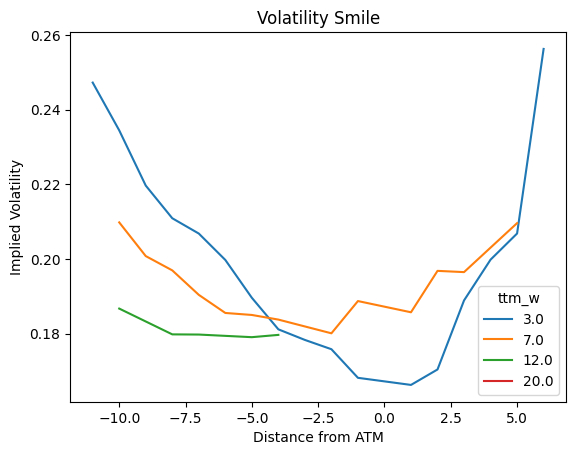

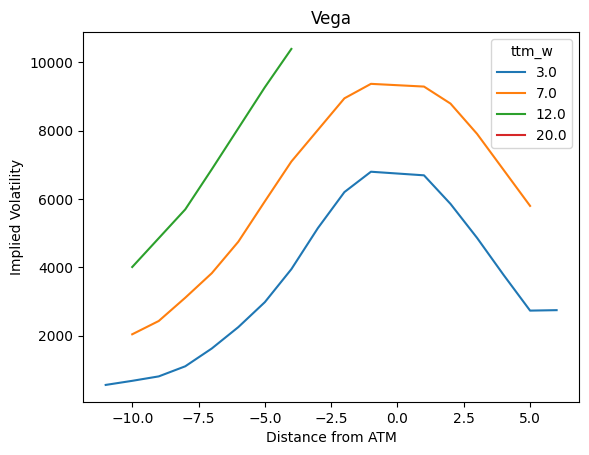

In [15]:
def plot_IV(d_clean, t, type = 'C'): # 允许plot ttm_w= = 0
    
    global iv_intp
    global vega_intp
    global iv
    global vega
    global d_temp
        
    d_temp = d_clean.loc[idx[:, type, t, :, :, :, :, :, :, :, :], idx[:]].reset_index(drop = True).set_index(['date', 'ttm_w', 'dist_mode']).unstack('dist_mode').sort_index(level = ['date', 'ttm_w'])
    
    iv = d_temp.loc[t, 'IV'].dropna(axis = 1, how = 'all')
    vega = d_temp.loc[t, 'vega'].dropna(axis = 1, how = 'all')

    # 转置&差值
    iv_intp = iv.T.interpolate(axis = 0, limit_area = 'inside')
    vega_intp = vega.T.interpolate(axis = 0, limit_area = 'inside')     

    plt.plot(iv_intp)
    plt.legend(iv_intp.columns, title = 'ttm_w')
    plt.title('Volatility Smile')
    plt.xlabel('Distance from ATM')
    plt.ylabel('Implied Volatility')
    
    fig, ax = plt.subplots()
    ax.plot(vega_intp)
    ax.set_title('Vega')
    ax.legend(iv_intp.columns, title = 'ttm_w')
    ax.set_xlabel('Distance from ATM')
    ax.set_ylabel('Implied Volatility')
    
t = pd.to_datetime('2022-11-30 14:15:00')
plot_IV(d_clean, t, type = 'C')


In [16]:
# 求历史IV均值，作为train set benchmark

def plot_mean_IV(d_clean, t0, t1, ttm_w0, ttm_w1, type = 'C', cal_method = 'normal'):
    
    global iv_benchmark
    global iv_mean
    global reindex
    
    iv_mean = d_clean.sort_index().loc[idx[:, type, t0:t1, :, :, :, ttm_w0:ttm_w1, :, :, :, :, :], idx[:]]
    vega_mean = d_clean.sort_index().loc[idx[:, type, t0:t1, :, :, :, ttm_w0:ttm_w1, :, :, :, :, :], idx[:]]['vega']
    
    reindex = (iv_mean[['IV_valid', 'volume']].groupby(level = ['ttm_w', 'dist_mode']).apply(len) >= 200)[iv_mean[['IV_valid', 'volume']].groupby(level = ['ttm_w', 'dist_mode']).apply(len) >= 200].index# .hist()
    
    if cal_method == 'volume_weighted': # 对每个(dist_mode, ttm_w)的所有天数的IV进行成交量加权
        
        iv_benchmark = iv_mean[['IV_valid', 'volume']].groupby(level = ['ttm_w', 'dist_mode']).apply(lambda x: np.dot(x.IV_valid , x.volume / x.volume.sum())).reindex(reindex).unstack('dist_mode').sort_index(level = 'dist_mode', axis = 1).T

        vega_benchmark = vega_mean.groupby(level = ['ttm_w', 'dist_mode']).apply(np.mean).reindex(reindex).unstack('dist_mode').sort_index(level = 'dist_mode', axis = 1).T
        
    else:
    
        iv_benchmark = iv_mean.IV_valid.groupby(level = ['ttm_w', 'dist_mode']).apply(lambda x: x.dropna().mean()).reindex(reindex).unstack('dist_mode').sort_index(level = 'dist_mode', axis = 1).T
        vega_benchmark = vega_mean.groupby(level = ['ttm_w', 'dist_mode']).apply(np.mean).unstack('dist_mode').T
        vega_benchmark = vega_mean.groupby(level = ['ttm_w', 'dist_mode']).apply(np.mean).reindex(reindex).unstack('dist_mode').sort_index(level = 'dist_mode', axis = 1).T

    fig, ax = plt.subplots()
    ax.plot(iv_benchmark)
    ax.set_title('Historical Mean IV')
    ax.legend(iv_benchmark.columns, title = 'ttm_w')
    ax.set_xlabel('Distance from ATM')
    ax.set_ylabel('Implied Volatility')
    
    fig, ax = plt.subplots()
    ax.plot(vega_benchmark)
    ax.set_title('Historical Mean Vega')
    ax.legend(vega_benchmark.columns, title = 'ttm_w')
    ax.set_xlabel('Distance from ATM')
    ax.set_ylabel('Vega')


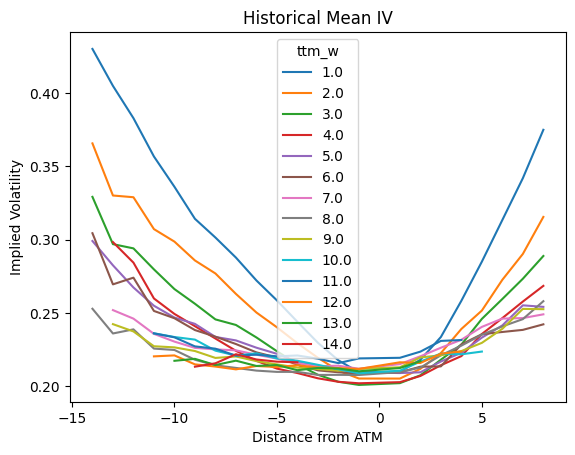

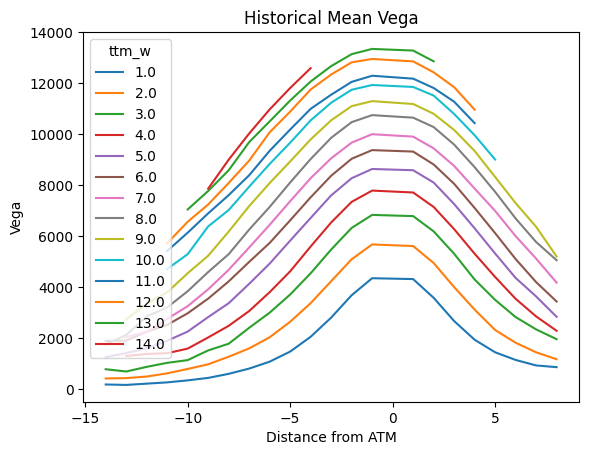

In [17]:
plot_mean_IV(d_clean, t0, t1, 1, 14, type = 'C', cal_method = 'volume_weightedno')

In [12]:
# 2023
t1 = '2023'
t2 = '2023'
d_day = open_pickle(path_in, 'd_23.pkl').sort_index()
d_test = open_pickle(path_in, 'd_23_clean.pkl').sort_index() # 测23年收益

In [13]:
d_day

limit_down  \
order_book_id type date       term dist_mode moneyness_interval ttm_w ttm_m moneyness_type               
CU2302C48000  C    2023-01-03 2302  18.0     (1.359, 1.393]     2.0   0.0   itm                11508.0   
                   2023-01-04 2302  17.0     (1.324, 1.359]     2.0   0.0   itm                11102.0   
                   2023-01-05 2302  17.0     (1.324, 1.359]     1.0   0.0   itm                10536.0   
                   2023-01-06 2302  18.0     (1.359, 1.393]     1.0   0.0   itm                 9698.0   
                   2023-01-09 2302  19.0     (1.359, 1.393]     1.0   0.0   itm                10634.0   
...                                                                                                ...   
CU2401P75000  P    2023-07-17 2401 -7.0      (0.874, 0.909]     23.0  5.0   itm                 3118.0   
                   2023-07-18 2401 -8.0      (0.874, 0.909]     22.0  5.0   itm                 3310.0   
                   2023-07-19 2401 -7.0      (0.874, 0.909]     22.0  5.0   itm                 3856.0   
                   2023-07-20 2401 -8.0      (0.874, 0.909]     22.0  5.0   itm                 3848.0   
                   2023-07-21 2401 -7.0      (0.874, 0.909]     22.0  5.0   itm                 3738.0   

                                                                                                low  \
order_book_id type date       term dist_mode moneyness_interval ttm_w ttm_m moneyness_type            
CU2302C48000  C    2023-01-03 2302  18.0     (1.359, 1.393]     2.0   0.0   itm             18120.0   
                   2023-01-04 2302  17.0     (1.324, 1.359]     2.0   0.0   itm             17670.0   
                   2023-01-05 2302  17.0     (1.324, 1.359]     1.0   0.0   itm             17040.0   
                   2023-01-06 2302  18.0     (1.359, 1.393]     1.0   0.0   itm             17238.0   
                   2023-01-09 2302  19.0     (1.359, 1.393]     1.0   0.0   itm             17150.0   
...                                                                                             ...   
CU2401P75000  P    2023-07-17 2401 -7.0      (0.874, 0.909]     23.0  5.0   itm              7234.0   
                   2023-07-18 2401 -8.0      (0.874, 0.909]     22.0  5.0   itm              7412.0   
                   2023-07-19 2401 -7.0      (0.874, 0.909]     22.0  5.0   itm              7916.0   
                   2023-07-20 2401 -8.0      (0.874, 0.909]     22.0  5.0   itm              7908.0   
                   2023-07-21 2401 -7.0      (0.874, 0.909]     22.0  5.0   itm              7802.0   

                                                                                            volume  \
order_book_id type date       term dist_mode moneyness_interval ttm_w ttm_m moneyness_type           
CU2302C48000  C    2023-01-03 2302  18.0     (1.359, 1.393]     2.0   0.0   itm                0.0   
                   2023-01-04 2302  17.0     (1.324, 1.359]     2.0   0.0   itm                0.0   
                   2023-01-05 2302  17.0     (1.324, 1.359]     1.0   0.0   itm                0.0   
                   2023-01-06 2302  18.0     (1.359, 1.393]     1.0   0.0   itm                4.0   
                   2023-01-09 2302  19.0     (1.359, 1.393]     1.0   0.0   itm                0.0   
...                                                                                            ...   
CU2401P75000  P    2023-07-17 2401 -7.0      (0.874, 0.909]     23.0  5.0   itm                0.0   
                   2023-07-18 2401 -8.0      (0.874, 0.909]     22.0  5.0   itm                0.0   
                   2023-07-19 2401 -7.0      (0.874, 0.909]     22.0  5.0   itm                0.0   
                   2023-07-20 2401 -8.0      (0.874, 0.909]     22.0  5.0   itm                0.0   
                   2023-07-21 2401 -7.0      (0.874, 0.909]     22.0  5.0   itm                0.0   

                                              

In [18]:
d_test = d_test.sort_index().loc[idx[:, ['C'], t1:t2], idx[:]][['moneyness_type', 'futures_price', 'close', 'ttm_w', 'dist_mode', 'volume', 'IV', 'IV_valid', 'vega']]
d_test = d_test[d_test['moneyness_type'] == 'otm']

arr1 = list(d_test.index.get_level_values('dist_mode'))
arr2 = list(d_test.index.get_level_values('ttm_w'))
arr = [arr1, arr2]

multi_index = pd.MultiIndex.from_arrays(arr, names=('dist_mode', 'ttm_w'))
iv_benchmark_exp = iv_benchmark.stack('ttm_w')

In [23]:
multi_index

MultiIndex([(-2.0,  2.0),
            (-2.0,  1.0),
            (-2.0,  2.0),
            (-3.0,  2.0),
            (-3.0,  1.0),
            (-2.0,  1.0),
            (-3.0,  2.0),
            (-4.0,  2.0),
            (-4.0,  1.0),
            (-3.0,  1.0),
            ...
            (-5.0, 22.0),
            (-6.0, 23.0),
            (-6.0, 23.0),
            (-7.0, 22.0),
            (-6.0, 22.0),
            (-6.0, 22.0),
            (-7.0, 23.0),
            (-8.0, 22.0),
            (-7.0, 22.0),
            (-7.0, 22.0)],
           names=['dist_mode', 'ttm_w'], length=7019)

In [20]:
iv_benchmark

ttm_w,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
dist_mode,,,,,,,,,,,,,,
-14.0,0.429917,0.365555,0.329121,NaN,0.299043,0.304351,NaN,0.252886,NaN,NaN,NaN,NaN,NaN,NaN
-13.0,0.404735,0.330043,0.296904,0.298297,0.282476,0.269506,0.251962,0.236042,0.242396,NaN,NaN,NaN,NaN,NaN
-12.0,0.382745,0.328867,0.294023,0.284312,0.267386,0.274061,0.246156,0.238845,0.237427,NaN,NaN,NaN,NaN,NaN
-11.0,0.356618,0.307149,0.279711,0.259893,0.254933,0.251396,0.235774,0.225744,0.227336,0.236162,0.236113,0.220443,NaN,NaN
-10.0,0.336002,0.298628,0.266293,0.249358,0.246895,0.246416,0.230504,0.224803,0.226575,0.233626,0.233427,0.221094,0.217419,NaN
-9.0,0.314168,0.285785,0.256293,0.241020,0.242580,0.238365,0.226223,0.218131,0.224081,0.231861,0.227249,0.214997,0.218758,0.213403
-8.0,0.301410,0.276918,0.245628,0.232592,0.233683,0.233853,0.225203,0.214359,0.219381,0.224341,0.225680,0.213497,0.214528,0.215712
-7.0,0.287753,0.263004,0.241842,0.224235,0.231315,0.228848,0.224554,0.212578,0.220373,0.220989,0.220930,0.211587,0.217516,0.221911
-6.0,0.272158,0.250329,0.233334,0.217400,0.226354,0.223160,0.221568,0.210741,0.217190,0.222517,0.221604,0.213879,0.213894,0.218314


In [19]:
iv_benchmark_exp

dist_mode  ttm_w
-14.0      1.0      0.429917
           2.0      0.365555
           3.0      0.329121
           5.0      0.299043
           6.0      0.304351
                      ...   
 8.0       5.0      0.254174
           6.0      0.242273
           7.0      0.249086
           8.0      0.258033
           9.0      0.252589
Length: 259, dtype: float64

In [21]:
d_test['iv_benchmark'] = iv_benchmark_exp.reindex(multi_index).values

In [22]:
d_test

moneyness_type  \
order_book_id type date       term dist_mode moneyness_interval ttm_w ttm_m moneyness_type                  
CU2302C66000  C    2023-01-04 2302 -2.0      (0.978, 1.013]     2.0   0.0   otm                       otm   
                   2023-01-05 2302 -2.0      (0.943, 0.978]     1.0   0.0   otm                       otm   
CU2302C67000  C    2023-01-03 2302 -2.0      (0.978, 1.013]     2.0   0.0   otm                       otm   
                   2023-01-04 2302 -3.0      (0.943, 0.978]     2.0   0.0   otm                       otm   
                   2023-01-05 2302 -3.0      (0.943, 0.978]     1.0   0.0   otm                       otm   
...                                                                                                   ...   
CU2401C74000  C    2023-07-21 2401 -6.0      (0.909, 0.943]     22.0  5.0   otm                       otm   
CU2401C75000  C    2023-07-17 2401 -7.0      (0.874, 0.909]     23.0  5.0   otm                       otm   
                   2023-07-18 2401 -8.0      (0.874, 0.909]     22.0  5.0   otm                       otm   
                   2023-07-19 2401 -7.0      (0.874, 0.909]     22.0  5.0   otm                       otm   
                   2023-07-21 2401 -7.0      (0.874, 0.909]     22.0  5.0   otm                       otm   

                                                                                            futures_price  \
order_book_id type date       term dist_mode moneyness_interval ttm_w ttm_m moneyness_type                  
CU2302C66000  C    2023-01-04 2302 -2.0      (0.978, 1.013]     2.0   0.0   otm                   64560.0   
                   2023-01-05 2302 -2.0      (0.943, 0.978]     1.0   0.0   otm                   64290.0   
CU2302C67000  C    2023-01-03 2302 -2.0      (0.978, 1.013]     2.0   0.0   otm                   65790.0   
                   2023-01-04 2302 -3.0      (0.943, 0.978]     2.0   0.0   otm                   64560.0   
                   2023-01-05 2302 -3.0      (0.943, 0.978]     1.0   0.0   otm                   64290.0   
...                                                                                                   ...   
CU2401C74000  C    2023-07-21 2401 -6.0      (0.909, 0.943]     22.0  5.0   otm                   68010.0   
CU2401C75000  C    2023-07-17 2401 -7.0      (0.874, 0.909]     23.0  5.0   otm                   68000.0   
                   2023-07-18 2401 -8.0      (0.874, 0.909]     22.0  5.0   otm                   67720.0   
                   2023-07-19 2401 -7.0      (0.874, 0.909]     22.0  5.0   otm                   68000.0   
                   2023-07-21 2401 -7.0      (0.874, 0.909]     22.0  5.0   otm                   68010.0   

                                                                                            close  \
order_book_id type date       term dist_mode moneyness_interval ttm_w ttm_m moneyness_type          
CU2302C66000  C    2023-01-04 2302 -2.0      (0.978, 1.013]     2.0   0.0   otm             296.0   
                   2023-01-05 2302 -2.0      (0.943, 0.978]     1.0   0.0   otm             208.0   
CU2302C67000  C    2023-01-03 2302 -2.0      (0.978, 1.013]     2.0   0.0   otm             364.0   
                   2023-01-04 2302 -3.0      (0.943, 0.978]     2.0   0.0   otm             142.0   
                   2023-01-05 2302 -3.0      (0.943, 0.978]     1.0   0.0   otm             100.0   
...                                                                                           ...   
CU2401C74000  C    2023-07-21 2401 -6.0      (0.909, 0.943]     22.0  5.0   otm             742.0   
CU2401C75000  C    2023-07-17 2401 -7.0      (0.874, 0.909]     23.0  5.0   otm             716.0   
                   2023-07-18 2401 -8.0      (0.874, 0.909]     22.0  5.0   otm             642.0   
                   2023-07-19 2401 -7.0      (0.874, 0.909]     22.0  5.0   otm             614.0   
                   2023-07-21 2401 -7.0    

In [24]:
# 分出测试集寻找信号点

# 2023
t1 = '2023'
t2 = '2023'
d_day = open_pickle(path_in, 'd_23.pkl').sort_index()
d_test = open_pickle(path_in, 'd_23_clean.pkl').sort_index() # 测23年收益

# 2022
# t0 = pd.to_datetime('2021-01-01') 
# t1 = t0 + dt.timedelta(weeks=52)
# t2 = t1 + dt.timedelta(weeks=52)
# d_day = open_pickle(path_in, 'd_cu_close.pkl').sort_index()
# d_test = open_pickle(path_in, 'd_cu_close_clean.pkl').sort_index() 

# 选出otm的数据
d_test = d_test.sort_index().loc[idx[:, ['C'], t1:t2], idx[:]][['moneyness_type', 'futures_price', 'close', 'ttm_w', 'dist_mode', 'volume', 'IV', 'IV_valid', 'vega']]
d_test = d_test[d_test['moneyness_type'] == 'otm']

arr1 = list(d_test.index.get_level_values('dist_mode'))
arr2 = list(d_test.index.get_level_values('ttm_w'))
arr = [arr1, arr2]

multi_index = pd.MultiIndex.from_arrays(arr, names=('dist_mode', 'ttm_w'))
iv_benchmark_exp = iv_benchmark.stack('ttm_w')

d_test['iv_benchmark'] = iv_benchmark_exp.reindex(multi_index).values
d_test = d_test.dropna(subset = 'iv_benchmark')
d_test = d_test[['IV_valid', 'vega', 'iv_benchmark']].reset_index().set_index(['date', 'ttm_w', 'dist_mode'], drop = False)
d_test = d_test.sort_index(level = ['date', 'ttm_w', 'dist_mode'])
d_test.set_index(['order_book_id'], append = True, drop = False, inplace = True)

In [15]:
# d_day.rename(columns={'IV': 'IV_valid'}, inplace=True)
# 22年数据集可能存在问题

In [25]:
# 策略信号

# smile信号
def get_sig_A(df):

    o_list = []
    for i in range(len(df) - 1):

        df_temp = df[i:i+2]
        # o_val = double_diff(df_temp.iv_benchmark.iloc[0], df_temp.IV_valid.iloc[0], df_temp.IV_valid.iloc[1], df_temp.iv_benchmark.iloc[1])
        o_val = df_temp.iv_benchmark.iloc[0] - df_temp.IV_valid.iloc[0] + df_temp.IV_valid.iloc[1] - df_temp.iv_benchmark.iloc[1]

        o_list.append(o_val)
    
    return o_list

# 计算预期收敛
def cal_converge(x):
    try:
        # conv = double_diff(x.iv_benchmark[1], x.IV_valid[1], x.IV_valid[0], x.iv_benchmark[0])
        conv = x.iv_benchmark[1]-x.IV_valid[1]+x.IV_valid[0]-x.iv_benchmark[0] 

        return conv
        
    except:
#         return 'missing pair with {} only'.format(x.index.get_level_values('order_book_id')[0]) # 如果存在missing pair, 会return那个存在的，而不是缺失的
        return np.nan 

# 对比预期收敛和实际收敛
def test_converge(d_clean, d_test, t, ttm_w, step = True):
    
    df = d_test.loc[(t, ttm_w)]
    o_list = get_sig_A(df)

    if len(o_list) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan # 当step = False只有6个columns输出6个nan

    pair_df = df.iloc[np.argmax(o_list) : np.argmax(o_list)+2]
    pair = pair_df.order_book_id.tolist()
    pair_iv_ts = d_clean.loc[idx[pair, :, str(t.date()):], idx[:]][['IV_valid']].reset_index().set_index(['date', 'ttm_w', 'order_book_id'], drop = False)[['IV_valid', 'dist_mode']].unstack(['order_book_id'])

    
    checkpoint = pair_iv_ts.reset_index('ttm_w')[['ttm_w', 'dist_mode']].dropna(thresh = 3)
    checkpoint['itm'] = (checkpoint.dist_mode > 0).any(axis = 1)
    checkpoint['ttm_w_sft'] = (checkpoint.ttm_w - checkpoint.ttm_w.shift(1) != 0)
    checkpoint.loc[t, 'ttm_w_sft'] = True
    
    if len(checkpoint) <= 1:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    
    if checkpoint.itm.argmax() > 0:
        checkpoint = checkpoint[:checkpoint.itm.argmax() + 1]
        
    if checkpoint[['itm', 'ttm_w_sft']].any(axis = 1).any():
        checkpoint = checkpoint[checkpoint[['itm', 'ttm_w_sft']].any(axis = 1)]
        
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        
    checkpoint_id = checkpoint.index
    
    
    if step == True: 
    # 如需计算整个ts的converge_exp，converge_accum，converge_step，可以看到每个step的对信号的胜率反馈，缺点是耗时
    
        pair_iv_stack = pair_iv_ts.stack('order_book_id')
        multi_index = pair_iv_stack.reset_index().set_index(['dist_mode', 'ttm_w']).index 
        pair_iv_stack['iv_benchmark'] = iv_benchmark_exp.reindex(multi_index).values # iv_benchmark_exp在plot函数中被global更新

        converge_exp = pair_iv_stack.groupby(level = ('date')).apply(cal_converge)
        
        pair_iv_ts['converge_exp'] = converge_exp.values # 按日期一一对应
        pair_iv_ts['converge_accum'] = pair_iv_ts.IV_valid.iloc[:, 1] - pair_iv_ts.IV_valid.iloc[0, 1] + pair_iv_ts.IV_valid.iloc[0, 0] - pair_iv_ts.IV_valid.iloc[:, 0] # 开仓持有到该点的总波动率收敛
        pair_iv_ts['converge_step'] = pair_iv_ts.IV_valid.iloc[:, 1].diff(periods = 1) + pair_iv_ts.IV_valid.iloc[:, 0].diff(periods = -1).shift(1)

        step_win_rate = (pair_iv_ts.converge_exp * pair_iv_ts.converge_step.shift(-1)).dropna().gt(0).mean() # 每个时间节点的胜率，不论平仓与否
        precision_rate = (pair_iv_ts.converge_exp * pair_iv_ts.converge_step.shift(-1))[pair_iv_ts.converge_exp.gt(0)].dropna().gt(0).mean()
        converge_exp = pair_iv_ts.loc[checkpoint_id].converge_exp
        close_id = min(converge_exp.lt(0).argmax() if converge_exp.lt(0).any() else (len(converge_exp) - 1), converge_exp.isnull().argmax() if converge_exp.isnull().any() else np.inf, len(converge_exp) - 1) # 当第一个checkpoint就为nan时会return 0，直接平仓，如果没有nan也没有小于0，则在最后一个datetime品仓      
        close_loc = converge_exp.index[close_id]
        converge = pair_iv_ts.converge_accum.loc[close_loc] 
    
        return np.max(o_list), converge, step_win_rate, precision_rate, close_loc[0], pair_iv_ts.dist_mode.iloc[0].values, pair_iv_ts.dist_mode.loc[close_loc].values

    else: 
        
    # 如只计算checkpoint的converge_exp，converge_accum，converge_step，只在(dist, ttm_w)其一发生变化是reevluate object function
        checkpoint = pair_iv_ts.loc[checkpoint_id].stack('order_book_id') 
        multi_index = checkpoint.reset_index().set_index(['dist_mode', 'ttm_w']).index
        checkpoint['iv_benchmark'] = iv_benchmark_exp.reindex(multi_index).values
        
        converge_exp = checkpoint.groupby(level = ('date')).apply(lambda x: double_diff(x.iv_benchmark[1], x.IV_valid[1], x.IV_valid[0], x.iv_benchmark[0]))
        # converge_exp = checkpoint.groupby(level = ('date')).apply(lambda x: x.iv_benchmark[1] - x.IV_valid[1] + x.IV_valid[0] - x.iv_benchmark[0])
        
        close_id = min(converge_exp.lt(-0.001).argmax() if converge_exp.lt(-0.001).any() else (len(converge_exp) - 1), converge_exp.isnull().argmax() \
                       if converge_exp.isnull().any() else np.inf, len(converge_exp) - 1) # inf是为防所有都为nan的情况
        close_loc = converge_exp.index[close_id]
        converge = pair_iv_ts.loc[close_loc].IV_valid.iloc[0, 1] - pair_iv_ts.IV_valid.iloc[0, 1] + pair_iv_ts.IV_valid.iloc[0, 0] - pair_iv_ts.loc[close_loc].IV_valid.iloc[0, 0]

        return pair, t, close_loc, converge_exp.iloc[0], converge, pair_iv_ts.dist_mode.iloc[0].values, pair_iv_ts.dist_mode.loc[close_loc].values

In [26]:
# 遍历所有states

test_id_unique = d_test.IV_valid.reset_index().set_index(['date', 'ttm_w']).index.unique()
test_id_unique

results = []
for t, ttm_w in test_id_unique: # 以(t, ttm_w)为单位，即每个单位为一个smile，这里纯粹计算波动率收敛，未考虑vega
    result = test_converge(d_day, d_test, t, ttm_w, step = False)
    results.append(result)


In [18]:

results = pd.DataFrame(results, index = test_id_unique, columns = ['pair', 'open_t', 'close_t', 'converge_exp', 'converge', 'open_dist_mode', 'close_dist_mode'])
results = results.dropna().sort_values(by = 'converge_exp', ascending = False)
payoff_ts = results.dropna().sort_values(by = ['open_t'])
payoff_ts = payoff_ts[payoff_ts.converge_exp > 0.015]
payoff_ts['pre_close_t'] = payoff_ts.close_t.shift(1)
# payoff_ts = payoff_ts[payoff_ts.open_t > payoff_ts.pre_close_t]

open_lst = [payoff_ts.open_t[0]]
close_t = payoff_ts.close_t[0]
for i,j in zip(payoff_ts.open_t[1:], payoff_ts.close_t[1:]):
    
    if i > close_t:
        open_lst.append(i)
        close_t = j

payoff_ts = payoff_ts.loc[open_lst][~payoff_ts.loc[open_lst].index.get_level_values('date').duplicated(keep = 'first')]

In [ ]:
# 2022波动率收敛最大值，一手组合赚722*5
# d_day.loc[idx[['CU2206C79000', 'CU2206C78000'], : , '2022-03-08':'2022-03-10'], ][['close', 'IV_valid', 'futures_price', 'volume']]

In [22]:
# d_15 = open_pickle(path_in, 'd_cu_15min.pkl') # 测22年收益
# d_15.sort_index(inplace=True) # 导入文件时出现index未排序问题
d_15 = open_pickle(path_in, 'd_cu_15min_23.pkl') # 测23年收益
d_15_sub = d_15.loc[idx[:,:,payoff_ts.index.get_level_values('date')[0]:(str(payoff_ts.close_t[-1]))], idx[:]]

In [23]:
# 计算PnL

payoff_lst = []
hedge_payoff_lst = []

for index, row in payoff_ts.iterrows():
    d_temp = d_15_sub.loc[idx[row.pair, :, (str(row.open_t.date()) + ' 15:00:00'):(str(row.close_t.date()) + ' 15:00:00')], idx[:]]

    d_temp['IV'] = d_temp.apply(lambda x: implied_volatility_binary(x.close, x.futures_price, x.strike, r, r, x.ttm_y, x.type), axis = 1)
    
    mask_c = d_temp.type == 'C'
    d_c = d_temp[mask_c]
    d_temp.loc[mask_c, 'delta'] = d_temp.apply(lambda x: delta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'C', 'long'), axis = 1) # delta只有在ttm=0时才会为nan
    mask_p = d_temp.type == 'P'
    d_p = d_temp[mask_p]
    d_temp.loc[mask_p, 'delta'] = d_temp.apply(lambda x: delta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'P', 'long'), axis = 1)
    # Gamma不分call/put
    d_temp.loc[:, 'gamma'] = d_temp.apply(lambda x: gamma_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y), axis = 1)
    # Vega
    d_temp.loc[:, 'vega'] = d_temp.apply(lambda x: vega_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y), axis = 1)
    # Theta
    d_temp.loc[mask_c, 'theta'] = d_temp.apply(lambda x: theta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'C'), axis = 1)
    d_temp.loc[mask_p, 'theta'] = d_temp.apply(lambda x: theta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'P'), axis = 1)
    
    # non delta-hedged
    payoff = d_temp[d_temp.index.get_level_values('date').astype(str).str.contains('15:00:00')].reset_index(drop = True).set_index(['options', 'date']).unstack('options')
#     payoff = d_temp.set_index(['options', 'date']).unstack('options')
    
    conv_check = copy.deepcopy(payoff)
    payoff = conv_check.close
    payoff.sort_index(level = 'options', axis = 1, inplace = True)
    payoff = payoff.iloc[-1, 1] - payoff.iloc[0, 1] + payoff.iloc[0, 0] - payoff.iloc[-1, 0]
    payoff_lst.append(payoff)
    
    d_temp = d_15_sub.loc[idx[row.pair,:, (str(row.open_t.date()) + ' 15:00:00'):(str(row.close_t.date()) + ' 15:00:00')], idx[:]]
    d_temp['IV'] = d_temp.apply(lambda x: implied_volatility_binary(x.close, x.futures_price, x.strike, r, r, x.ttm_y, x.type), axis = 1)
    mask_c = d_temp.type == 'C'
    d_c = d_temp[mask_c]
    d_temp.loc[mask_c, 'delta'] = d_temp.apply(lambda x: delta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'C', 'long'), axis = 1) # delta只有在ttm=0时才会为nan
    mask_p = d_temp.type == 'P'
    d_p = d_temp[mask_p]
    d_temp.loc[mask_p, 'delta'] = d_temp.apply(lambda x: delta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'P', 'long'), axis = 1)
    # Gamma不分call/put
    d_temp.loc[:, 'gamma'] = d_temp.apply(lambda x: gamma_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y), axis = 1)
    # Vega
    d_temp.loc[:, 'vega'] = d_temp.apply(lambda x: vega_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y), axis = 1)
    # Theta
    d_temp.loc[mask_c, 'theta'] = d_temp.apply(lambda x: theta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'C'), axis = 1)
    d_temp.loc[mask_p, 'theta'] = d_temp.apply(lambda x: theta_option(x.futures_price, x.strike, x.IV, r, r, x.ttm_y, 'P'), axis = 1)

    
    d_temp = d_temp.reset_index(drop = True).set_index(['options', 'date']).unstack('options')[['futures_price', 'delta']]
    d_temp['delta_f'] = (d_temp.delta.iloc[:,0] - d_temp.delta.iloc[:,1]).shift(1)
    d_temp['price_chg'] = d_temp.futures_price.iloc[:,0].diff()
    d_temp['delta_profit'] = d_temp.delta_f*d_temp.price_chg
    hedge_payoff_lst.append(d_temp['delta_profit'].sum())
    

payoff_ts['payoff'] = np.array(payoff_lst) + np.array(hedge_payoff_lst)
payoff_ts['payoff'].sum()
payoff_ts[payoff_ts.payoff < 0]

,,pair,open_t,close_t,converge_exp,converge,open_dist_mode,close_dist_mode,pre_close_t,payoff
date,ttm_w,,,,,,,,,


hedged portfolio return:  0.08
一手总收益(截至7月):  1602.8342103430714
Sharpe ratio is: 0.6081118318204309


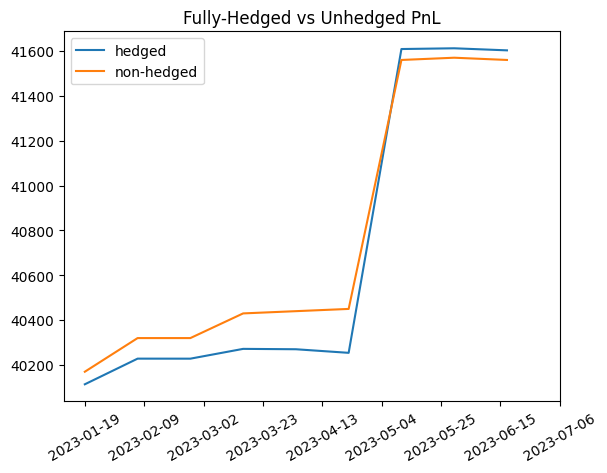

In [26]:
# 2023

print('hedged portfolio return: ', 2*round((5*payoff_ts.payoff.sum()-len(payoff_ts)*20)/40000, 3)) # 半年收益*2

print('一手总收益(截至7月): ', 5*payoff_ts.payoff.sum()-len(payoff_ts)*20)

def get_sharpe(balance):
    return balance.pct_change().mean() / balance.pct_change().std()
    
print('Sharpe ratio is:', np.sqrt(2)*round(get_sharpe(payoff_ts.payoff.cumsum() + 40000), 2)) 
# 因为半年内9比交易收益始终为正，收益率的std比较的都是正收益间的差距，越大的收益反而会降低夏普，所以只有0.61

fig, ax = plt.subplots()
ax.plot((payoff_ts.payoff*5-20).cumsum().values + 40000, label = 'hedged')
ax.set_xticks(np.linspace(0, 9, 9))
t = pd.date_range(start='2023-01-19',
                  end='2023-07-06',  
                  periods=9)
ax.set_xticklabels(t.date, rotation=30, fontsize=10)
# ax.set_title('Fully-Hedged PnL')


ax.plot(((payoff_ts.payoff-np.array(hedge_payoff_lst))*5-20).cumsum().values + 40000, label = 'non-hedged')
ax.set_xticks(np.linspace(0, 9, 9))

ax.set_title('Fully-Hedged vs Unhedged PnL')
ax.legend()


In [27]:
payoff_ts # 2023

,,pair,open_t,close_t,converge_exp,converge,open_dist_mode,close_dist_mode,pre_close_t,payoff
date,ttm_w,,,,,,,,,
2023-01-19,4.0,"[CU2303C82000, CU2303C80000]",2023-01-19,2023-02-09,0.024852,0.032456,"[-11.0, -13.0]","[[-12.0, -14.0]]",NaT,26.794730
2023-02-21,4.0,"[CU2304C82000, CU2304C80000]",2023-02-21,2023-03-14,0.030642,0.058413,"[-10.0, -12.0]","[[-12.0, -14.0]]",2023-02-07,26.873471
2023-03-17,1.0,"[CU2304C78000, CU2304C77000]",2023-03-17,2023-03-21,0.020868,0.023661,"[-10.0, -11.0]","[[-10.0, -11.0]]",2023-03-14,3.975518
2023-03-24,4.0,"[CU2305C82000, CU2305C80000]",2023-03-24,2023-04-11,0.019471,0.025713,"[-11.0, -13.0]","[[-12.0, -14.0]]",2023-03-21,12.734116
2023-04-26,4.0,"[CU2306C79000, CU2306C78000]",2023-04-26,2023-04-28,0.019770,0.011345,"[-11.0, -12.0]","[[-11.0, -12.0]]",2023-04-18,3.662645
2023-05-05,2.0,"[CU2306C79000, CU2306C77000]",2023-05-05,2023-05-12,0.019710,0.007467,"[-11.0, -13.0]","[[-13.0, -15.0]]",2023-04-28,0.800921
2023-05-22,13.0,"[CU2309C67000, CU2309C66000]",2023-05-22,2023-06-05,0.019932,0.020943,"[-2.0, -3.0]","[[-1.0, -2.0]]",2023-05-19,274.901311
2023-06-16,1.0,"[CU2307C76000, CU2307C75000]",2023-06-16,2023-06-20,0.016126,0.040048,"[-7.0, -8.0]","[[-7.0, -8.0]]",2023-06-05,4.662055
2023-07-06,2.0,"[CU2308C80000, CU2308C78000]",2023-07-06,2023-07-12,0.022603,0.051668,"[-11.0, -13.0]","[[-11.0, -13.0]]",2023-06-20,2.162075


In [ ]:
# 文件比较多，用到的都在pickle文件中，因为每个文件都进行了不一样的数据清理，只要打开文件看格式再找对应代码即可，其他文件均可删除

# 已按要求完成2023年回测